In [62]:
from utils.base_data_handler import BaseDataHandler

california_handler = BaseDataHandler(path='2025-12-09/california_housing_data.csv')
california_handler.try_clean_column_names()
california_handler.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   med_inc        20640 non-null  float64
 1   house_age      20640 non-null  float64
 2   ave_rooms      20640 non-null  float64
 3   ave_bedrms     20640 non-null  float64
 4   population     20640 non-null  float64
 5   ave_occup      20640 non-null  float64
 6   latitude       20640 non-null  float64
 7   longitude      20640 non-null  float64
 8   med_house_val  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [63]:
from math import radians, sin, cos, sqrt, atan2
import numpy as np

# --- 1. Coastline Distance Calculation ---
# Crescent City, Point Arena, SF outer coast, Monterey, Santa Barbara, LA, San Diego
_LAT = np.array([41.8, 39.0, 37.7, 36.6, 34.4, 34.0, 32.7])
_LON = np.array([-124.2, -123.7, -122.5, -121.9, -120.3, -118.5, -117.2])

# Quadratic fit: lon = a*lat^2 + b*lat + c
_COAST_COEFFS = np.polyfit(_LAT, _LON, deg=2)
def _coast_lon(lat):
    a, b, c = _COAST_COEFFS
    return a*lat*lat + b*lat + c

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Earth radius in km
    dlat = radians(lat2 - lat1)
    dlon = radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    return 2 * R * atan2(sqrt(a), sqrt(1-a))

def coast_distance(lat, lon):
    # Approximates the longitude on the fitted coastline at the given latitude
    coast_lon = _coast_lon(lat)
    # This distance is an approximation using Haversine between the point and the coast projection
    return haversine(lat, lon, lat, coast_lon) 

# Add dist_to_coast column
_ = california_handler.try_add_col(target_col="dist_to_coast", func=lambda row: coast_distance(row['latitude'],row['longitude']))

relations_of_interest = {

    # households
    'est_households' : ('population', 'ave_occup'),
    'rooms_per_households' : ('ave_rooms', 'est_households'),
    'pop_per_households' : ('population', 'est_households'),
    'bedrms_per_household' : ('ave_bedrms', 'est_household'),
    'income_per_households' : ('med_inc', 'est_households'),

    # income
    'income_per_dist_coast' : ('med_inc', 'dist_to_coast'),
    'income_per_population' : ('med_inc','population'),
    'income_per_house_age' : ('med_inc','house_age'),
    'income_per_bedrms': ('med_inc', 'ave_bedrms'),
    'income_per_rooms': ('med_inc', 'ave_rooms'),
    'income_per_occup': ('med_inc','ave_occup'),
    
    # Rooms
    'rooms_per_age': ('ave_rooms','house_age'),
    'rooms_per_capita': ('ave_rooms','population'),
    'bedrms_per_rooms': ('ave_bedrms','ave_rooms'),
    'rooms_per_person': ('ave_rooms', 'ave_occup'), 
    'house_density': ('ave_occup', 'ave_rooms'), 
    'rooms_vs_bedrooms': ('ave_rooms', 'ave_bedrms'),
    
    'occup_per_bedrms': ('ave_occup','ave_bedrms'),
    'income_per_capita': ('med_inc', 'ave_occup'), 
    'pop_per_house_age': ('population', 'house_age'), 
    'age_per_dist_coast': ('house_age', 'dist_to_coast'),
}


for new_col, (col1, col2) in relations_of_interest.items():
    # Execute all ratio additions using the small constant (1e-6) to handle near-zero denominators
    california_handler.try_add_col(new_col, lambda r: r[col1] / (r[col2] + 1e-6))

# --- 4. Polynomial / Transformation Features ---

# Polynomial Term
california_handler.try_add_col('ave_rooms_squared', lambda r: r['ave_rooms'] **2)

# Log Transformations (Useful for highly skewed features)
california_handler.try_add_col('log_med_inc', lambda r: np.log1p(r['med_inc']))
california_handler.try_add_col('log_population', lambda r: np.log1p(r['population']))


# --- 5. Spatial Feature (Interaction) ---

# Latitude-Longitude Interaction (Captures unique spatial locations)
california_handler.try_add_col('lat_times_long', lambda r: r['latitude'] * r['longitude'])


california_handler.try_add_col('lat_sin', lambda r: np.sin(np.radians(r['latitude'])))
california_handler.try_add_col('lat_cos', lambda r: np.cos(np.radians(r['latitude'])))
california_handler.try_add_col('lon_sin', lambda r: np.sin(np.radians(r['longitude'])))
california_handler.try_add_col('lon_cos', lambda r: np.cos(np.radians(r['longitude'])))


# --- Final Check ---
california_handler.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 38 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   med_inc                20640 non-null  float64
 1   house_age              20640 non-null  float64
 2   ave_rooms              20640 non-null  float64
 3   ave_bedrms             20640 non-null  float64
 4   population             20640 non-null  float64
 5   ave_occup              20640 non-null  float64
 6   latitude               20640 non-null  float64
 7   longitude              20640 non-null  float64
 8   med_house_val          20640 non-null  float64
 9   dist_to_coast          20640 non-null  float64
 10  est_households         20640 non-null  float64
 11  rooms_per_households   20640 non-null  float64
 12  pop_per_households     20640 non-null  float64
 13  income_per_households  20640 non-null  float64
 14  income_per_dist_coast  20640 non-null  float64
 15  in

In [64]:
# --- 6. Distances to Key Cities ---
_SF_LAT, _SF_LON = 37.7749, -122.4194
_LA_LAT, _LA_LON = 34.0522, -118.2437
_SD_LAT, _SD_LON = 32.7157, -117.1611  # San Diego
_SJ_LAT, _SJ_LON = 37.3382, -121.8863  # San Jose

def dist_to_point(lat, lon, target_lat, target_lon):
    return haversine(lat, lon, target_lat, target_lon)

california_handler.try_add_col("dist_to_SF", lambda r: dist_to_point(r['latitude'], r['longitude'], _SF_LAT, _SF_LON))
california_handler.try_add_col("dist_to_LA", lambda r: dist_to_point(r['latitude'], r['longitude'], _LA_LAT, _LA_LON))
california_handler.try_add_col("dist_to_SD", lambda r: dist_to_point(r['latitude'], r['longitude'], _SD_LAT, _SD_LON))
california_handler.try_add_col("dist_to_SJ", lambda r: dist_to_point(r['latitude'], r['longitude'], _SJ_LAT, _SJ_LON))

# --- 7. Bounding Box Indicators for Major Cities ---
def in_bbox(lat, lon, bbox):
    return float(bbox['lat_min'] <= lat <= bbox['lat_max'] and bbox['lon_min'] <= lon <= bbox['lon_max'])

_LA_BBOX = {'lat_min': 33.5, 'lat_max': 34.5, 'lon_min': -119.0, 'lon_max': -117.5}
_SF_BBOX = {'lat_min': 37.5, 'lat_max': 38.0, 'lon_min': -122.6, 'lon_max': -122.2}

california_handler.try_add_col("is_in_LA", lambda r: in_bbox(r['latitude'], r['longitude'], _LA_BBOX))
california_handler.try_add_col("is_in_SF", lambda r: in_bbox(r['latitude'], r['longitude'], _SF_BBOX))

# --- 8. Additional Spatial Features ---
# Latitude / Longitude Interactions (sin/cos transforms already added)
california_handler.try_add_col("lat_long_sum", lambda r: r['latitude'] + r['longitude'])
california_handler.try_add_col("lat_long_diff", lambda r: r['latitude'] - r['longitude'])
california_handler.try_add_col("lat2_plus_lon2", lambda r: r['latitude']**2 + r['longitude']**2)

# --- 11. Polynomial / Transform Features ---
california_handler.try_add_col("house_age_squared", lambda r: r['house_age']**2)
california_handler.try_add_col("rooms_squared", lambda r: r['ave_rooms']**2)
california_handler.try_add_col("bedrms_squared", lambda r: r['ave_bedrms']**2)
california_handler.try_add_col("occup_squared", lambda r: r['ave_occup']**2)

# Log transforms for skewed features
california_handler.try_add_col("log_house_age", lambda r: np.log1p(r['house_age']))
california_handler.try_add_col("log_rooms", lambda r: np.log1p(r['ave_rooms']))
california_handler.try_add_col("log_bedrms", lambda r: np.log1p(r['ave_bedrms']))
california_handler.try_add_col("log_population", lambda r: np.log1p(r['population']))
california_handler.try_add_col("log_med_inc", lambda r: np.log1p(r['med_inc']))

# --- 12. Interaction Features ---
california_handler.try_add_col("rooms_times_bedrms", lambda r: r['ave_rooms'] * r['ave_bedrms'])
california_handler.try_add_col("rooms_times_occup", lambda r: r['ave_rooms'] * r['ave_occup'])
california_handler.try_add_col("bedrms_times_occup", lambda r: r['ave_bedrms'] * r['ave_occup'])
california_handler.try_add_col("rooms_times_house_age", lambda r: r['ave_rooms'] * r['house_age'])
california_handler.try_add_col("occup_times_house_age", lambda r: r['ave_occup'] * r['house_age'])

# --- 13. Final Check ---
california_handler.df.info()

# --- 2. Categorical/Indicator Features (Bounding Box Check) ---

# Define simple bounding boxes (approximations) for the metro areas
# These are heuristic and based on typical boundaries; may need fine-tuning
_LA_BOUNDING_BOX = {
    'lat_min': 33.5, 'lat_max': 34.5,
    'lon_min': -119.0, 'lon_max': -117.5
}
_SF_BOUNDING_BOX = {
    'lat_min': 37.5, 'lat_max': 38.0,
    'lon_min': -122.6, 'lon_max': -122.2
}


def is_in_la(lat, lon):
    """Checks if coordinates are within the defined LA bounding box."""
    return (
        _LA_BOUNDING_BOX['lat_min'] <= lat <= _LA_BOUNDING_BOX['lat_max'] and
        _LA_BOUNDING_BOX['lon_min'] <= lon <= _LA_BOUNDING_BOX['lon_max']
    )

def is_in_sf(lat, lon):
    """Checks if coordinates are within the defined SF bounding box."""
    return (
        _SF_BOUNDING_BOX['lat_min'] <= lat <= _SF_BOUNDING_BOX['lat_max'] and
        _SF_BOUNDING_BOX['lon_min'] <= lon <= _SF_BOUNDING_BOX['lon_max']
    )

# Add is_in_LA and is_in_SF columns (1.0 if True, 0.0 if False)
california_handler.try_add_col(
    target_col="is_in_LA",
    func=lambda row: True if is_in_la(row['latitude'], row['longitude']) else False
)

california_handler.try_add_col(
    target_col="is_in_SF",
    func=lambda row: True if is_in_sf(row['latitude'], row['longitude']) else False
)

# --- Final Check with new columns ---
california_handler.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 59 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   med_inc                20640 non-null  float64
 1   house_age              20640 non-null  float64
 2   ave_rooms              20640 non-null  float64
 3   ave_bedrms             20640 non-null  float64
 4   population             20640 non-null  float64
 5   ave_occup              20640 non-null  float64
 6   latitude               20640 non-null  float64
 7   longitude              20640 non-null  float64
 8   med_house_val          20640 non-null  float64
 9   dist_to_coast          20640 non-null  float64
 10  est_households         20640 non-null  float64
 11  rooms_per_households   20640 non-null  float64
 12  pop_per_households     20640 non-null  float64
 13  income_per_households  20640 non-null  float64
 14  income_per_dist_coast  20640 non-null  float64
 15  in

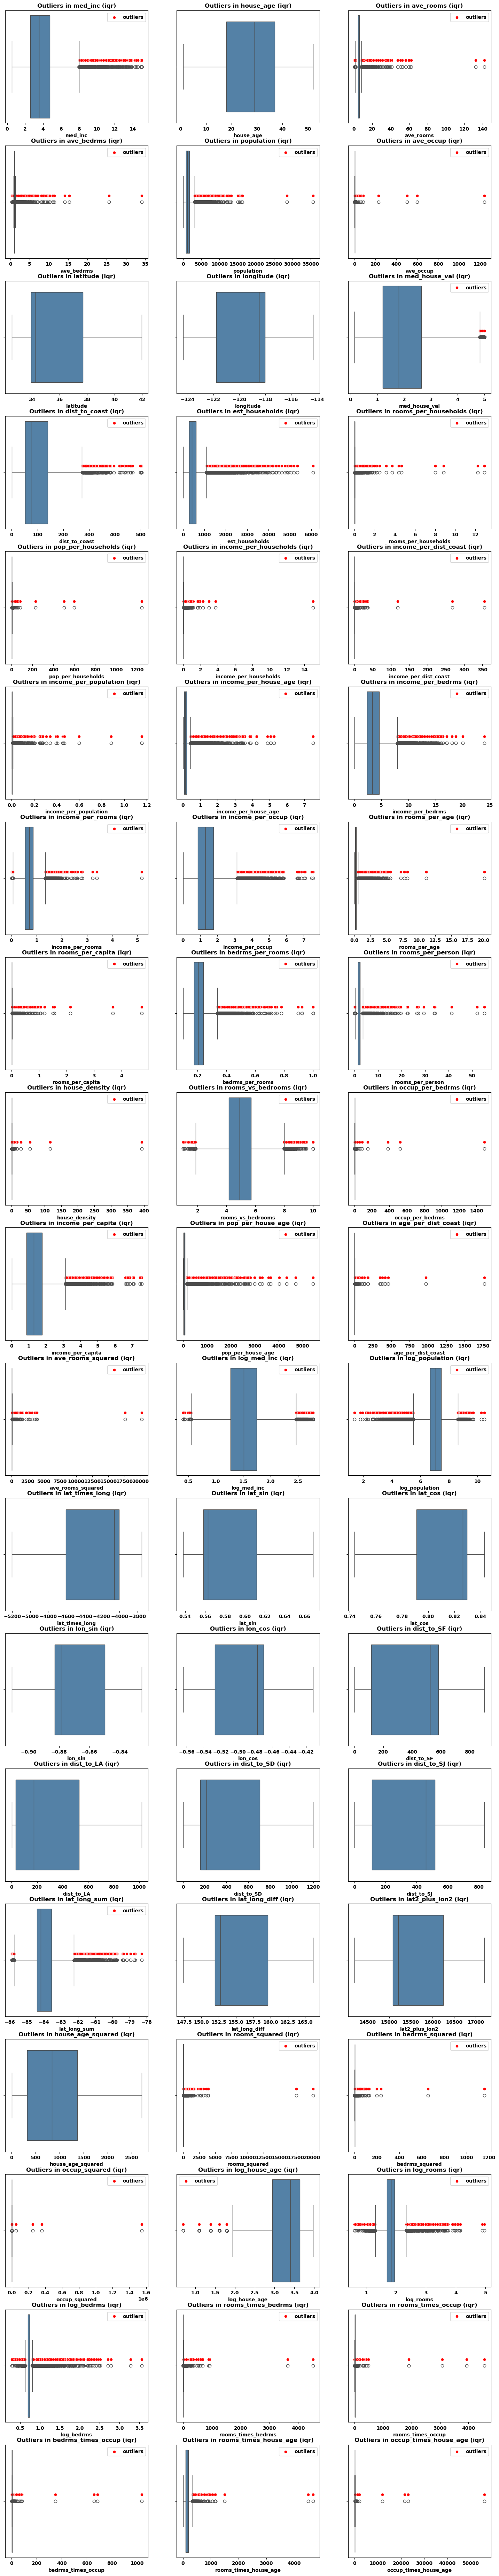

In [65]:
fig,ax = california_handler.get_outlier_case_study(method='iqr')

In [66]:
mask = california_handler.get_outliers_df()                 # DataFrame of flags
row_mask = mask.any(axis=1)                                 # collapse to single Series
california_handler.df = california_handler.df[~row_mask]    # keep only non-outliers
california_handler.df.dropna(inplace=True)
california_handler.df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15998 entries, 0 to 20639
Data columns (total 59 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   med_inc                15998 non-null  float64
 1   house_age              15998 non-null  float64
 2   ave_rooms              15998 non-null  float64
 3   ave_bedrms             15998 non-null  float64
 4   population             15998 non-null  float64
 5   ave_occup              15998 non-null  float64
 6   latitude               15998 non-null  float64
 7   longitude              15998 non-null  float64
 8   med_house_val          15998 non-null  float64
 9   dist_to_coast          15998 non-null  float64
 10  est_households         15998 non-null  float64
 11  rooms_per_households   15998 non-null  float64
 12  pop_per_households     15998 non-null  float64
 13  income_per_households  15998 non-null  float64
 14  income_per_dist_coast  15998 non-null  float64
 15  income_

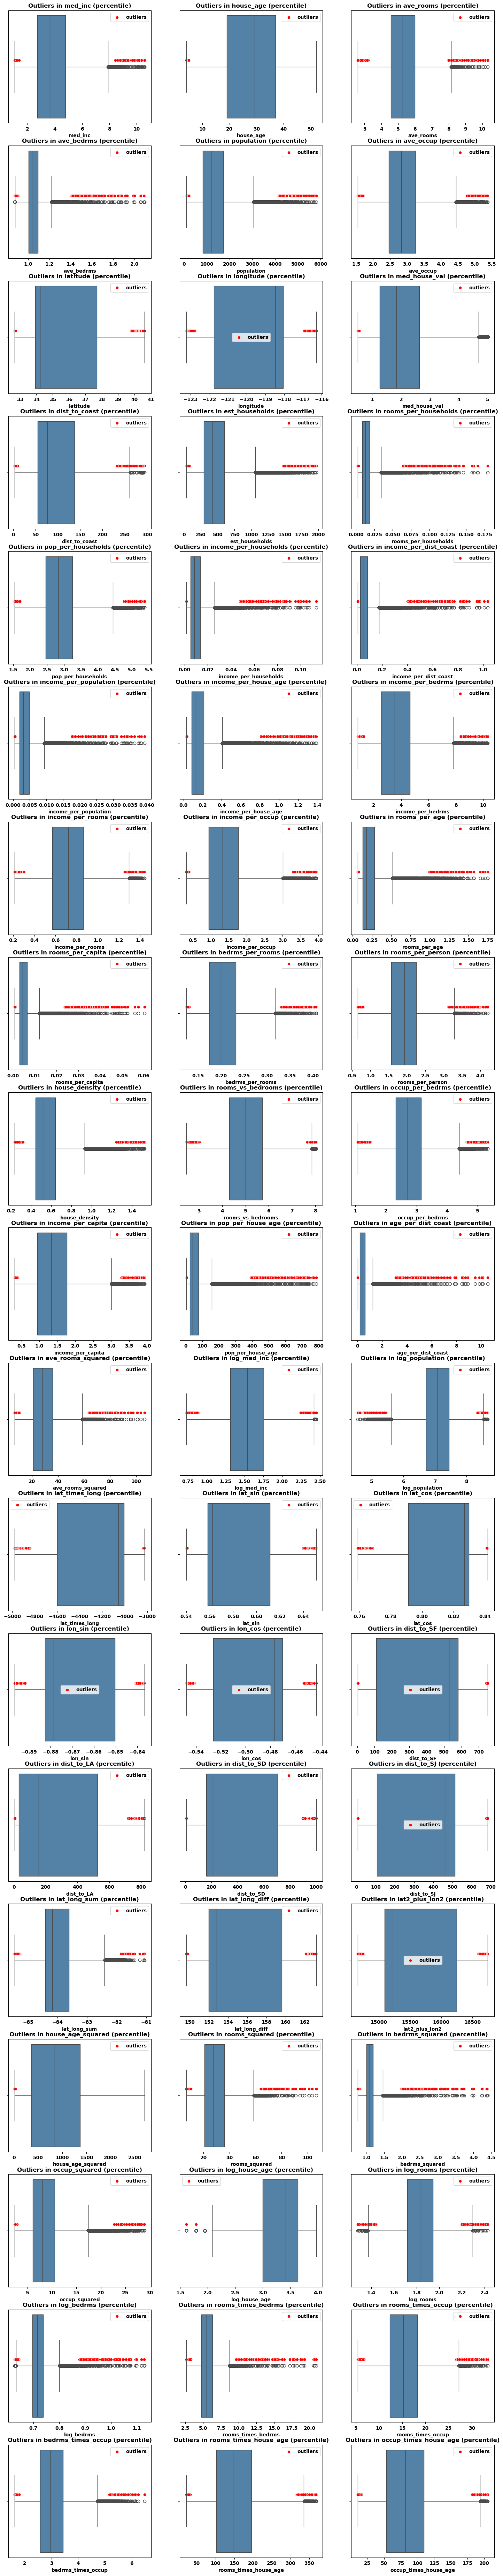

In [67]:
fig,ax = california_handler.get_outlier_case_study()


In [68]:
import optuna
import pandas as pd
import xgboost as xgb
from utils import functions
from sklearn.decomposition import PCA
from catboost import CatBoostRegressor
from sklearn.preprocessing import RobustScaler
from lightgbm import LGBMRegressor, early_stopping
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from optuna.integration import XGBoostPruningCallback, LightGBMPruningCallback, CatBoostPruningCallback

# ===============================
# User-configurable flag
# ===============================
USE_PCA = False
PCA_COMPONENTS = 23  # Only used if USE_PCA=True

# --- 1. Data Setup and Log Transformation ---
X, y = california_handler.get_training_data(target="med_house_val")

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Split for tuning (Train/Validation)
X_train_part, X_valid, y_train_part, y_valid = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# --- 2. Scaling ---
scaler = RobustScaler()
X_train_scaled_array = scaler.fit_transform(X_train)
X_test_scaled_array = scaler.transform(X_test)
X_train_part_scaled_array = scaler.transform(X_train_part)
X_valid_scaled_array = scaler.transform(X_valid)

# --- 3. Optional PCA ---
if USE_PCA:
    pca = PCA(n_components=PCA_COMPONENTS)
    X_train_pca = pca.fit_transform(X_train_scaled_array)
    X_test_pca = pca.transform(X_test_scaled_array)
    X_train_part_pca = pca.transform(X_train_part_scaled_array)
    X_valid_pca = pca.transform(X_valid_scaled_array)

    # PCA feature names for DataFrames
    feature_names = [f'pca_comp_{i+1}' for i in range(pca.n_components_)]
else:
    # Skip PCA, use scaled arrays directly
    X_train_pca = X_train_scaled_array
    X_test_pca = X_test_scaled_array
    X_train_part_pca = X_train_part_scaled_array
    X_valid_pca = X_valid_scaled_array

    feature_names = X_train.columns.tolist()  # Keep original feature names

# --- 4. Convert to DataFrame for LightGBM/Stacking ---
X_train_scaled_df = pd.DataFrame(X_train_pca, columns=feature_names)
X_test_scaled_df = pd.DataFrame(X_test_pca, columns=feature_names)
X_train_part_scaled_df = pd.DataFrame(X_train_part_pca, columns=feature_names)
X_valid_scaled_df = pd.DataFrame(X_valid_pca, columns=feature_names)

# --- 5. Log transform targets ---
y_train_log = np.log1p(y_train_part)
y_valid_log = np.log1p(y_valid)
y_train_full_log = np.log1p(y_train)

# --- 6. XGBoost DMatrix (always NumPy) ---
dtrain_part = xgb.DMatrix(X_train_part_pca, label=y_train_log)
dvalid = xgb.DMatrix(X_valid_pca, label=y_valid_log)
dtrain_full = xgb.DMatrix(X_train_pca, label=y_train_full_log)
dtest = xgb.DMatrix(X_test_pca)

print(f"Using PCA: {USE_PCA}, feature shape: {X_train_scaled_df.shape}")


Using PCA: False, feature shape: (12798, 58)


In [69]:

def objective_xgb(trial):
    ## --- 2. Search Space ---
    params = {
        "objective": "reg:squarederror",
        "tree_method": "hist",
        "device": "cpu",
        "verbosity": 0,
        "eval_metric": "rmse",
        
        # Hyperparameters to optimize
        'n_estimators': trial.suggest_int('n_estimators', 600, 2000),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "subsample": trial.suggest_float("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.6, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "lambda": trial.suggest_float("lambda", 1e-8, 10.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 10.0, log=True),
    }

    ## --- 3. Setup Pruning Callback ---
    # Monitors the RMSE of the validation set (named 'validation')
    pruning_callback = XGBoostPruningCallback(trial, "validation-rmse")

    ## --- 4. Run Training on Partial Data ---
    model = xgb.train(
        params,
        dtrain_part,
        num_boost_round=1000,
        evals=[(dvalid, 'validation')],
        early_stopping_rounds=50,
        callbacks=[pruning_callback],
        verbose_eval=False
    )

    # Return the best score (RMSE on log-prices)
    trial.set_user_attr("best_iteration", model.best_iteration)
    return model.best_score

def objective_lgbm(trial):
    params = {
        'objective': 'regression', 'metric': 'rmse', 'verbose': -1, 'n_jobs': -1,
        'n_estimators': trial.suggest_int('n_estimators', 600, 2000),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.05),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 30),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'random_state': 42
    }

    pruning_callback = LightGBMPruningCallback(trial, 'rmse')

    model = LGBMRegressor(**params)

    model.fit(
        X_train_part_scaled_df, y_train_log,
        eval_set=[(X_valid_scaled_df, y_valid_log)],
        eval_metric='rmse',
        callbacks=[pruning_callback, early_stopping(50, verbose=False)],
    )

    trial.set_user_attr('best_iteration', model.best_iteration_)
    return model.best_score_['valid_0']['rmse']


def objective_cat(trial):
    params = {
        'objective': 'RMSE',
        'verbose': 0,
        'random_seed': 42,
        'iterations': trial.suggest_int('iterations', 600, 1200),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 0.95),
        'rsm': trial.suggest_float('rsm', 0.6, 1.0),
        'allow_writing_files': False
    }

    pruning_callback = CatBoostPruningCallback(trial, 'RMSE')

    model = CatBoostRegressor(**params)

    model.fit(
        X_train_part_scaled_df, y_train_log,
        eval_set=[(X_valid_scaled_df, y_valid_log)],
        callbacks=[pruning_callback],
        early_stopping_rounds=50,
        verbose=0
    )

    trial.set_user_attr('best_iteration', model.best_iteration_)
    return model.get_best_score()['validation']['RMSE']


In [70]:
# --- Optimization Run ---
print("Optimizing XGBoost (using DMatrix)...")
study_xgb = optuna.create_study(direction="minimize", study_name="XGBoost_California")
study_xgb.optimize(objective_xgb, n_trials=50, show_progress_bar=False)

[I 2025-12-10 17:36:58,680] A new study created in memory with name: XGBoost_California


Optimizing XGBoost (using DMatrix)...


[I 2025-12-10 17:37:00,430] Trial 0 finished with value: 0.11029789421528524 and parameters: {'n_estimators': 1262, 'learning_rate': 0.08520699288275205, 'max_depth': 7, 'subsample': 0.9020235464954426, 'colsample_bytree': 0.8524832926043766, 'min_child_weight': 4, 'lambda': 2.132884516516964, 'alpha': 1.64565001302039e-07}. Best is trial 0 with value: 0.11029789421528524.
[I 2025-12-10 17:37:01,039] Trial 1 finished with value: 0.11335664405529261 and parameters: {'n_estimators': 785, 'learning_rate': 0.18801790290229342, 'max_depth': 8, 'subsample': 0.8396632375617813, 'colsample_bytree': 0.7628378594792606, 'min_child_weight': 6, 'lambda': 0.0020356038779717795, 'alpha': 0.22435061516467636}. Best is trial 0 with value: 0.11029789421528524.
[I 2025-12-10 17:37:01,903] Trial 2 finished with value: 0.11106435860745376 and parameters: {'n_estimators': 701, 'learning_rate': 0.09049758722297986, 'max_depth': 5, 'subsample': 0.6105963601187375, 'colsample_bytree': 0.8908202227686901, 'min

In [71]:
print("Optimizing LightGBM (using DMatrix)...")
study_lgbm = optuna.create_study(direction="minimize", study_name="LightGBM_California")
study_lgbm.optimize(objective_lgbm, n_trials=50, show_progress_bar=False)

[I 2025-12-10 17:37:11,454] A new study created in memory with name: LightGBM_California


Optimizing LightGBM (using DMatrix)...


[I 2025-12-10 17:37:11,835] Trial 0 finished with value: 0.1235875888821968 and parameters: {'n_estimators': 849, 'learning_rate': 0.021602828061381012, 'num_leaves': 90, 'max_depth': 3, 'min_child_samples': 27, 'colsample_bytree': 0.7620763317561848, 'subsample': 0.9591007277339951, 'reg_alpha': 2.0322709481141695e-06, 'reg_lambda': 0.0042531105714135094}. Best is trial 0 with value: 0.1235875888821968.
[I 2025-12-10 17:37:12,567] Trial 1 finished with value: 0.11182433315067633 and parameters: {'n_estimators': 640, 'learning_rate': 0.04250071249687325, 'num_leaves': 39, 'max_depth': 6, 'min_child_samples': 26, 'colsample_bytree': 0.9547745583776306, 'subsample': 0.9133615269071006, 'reg_alpha': 0.020870537165091102, 'reg_lambda': 0.07881595649965346}. Best is trial 1 with value: 0.11182433315067633.
[I 2025-12-10 17:37:13,046] Trial 2 finished with value: 0.11681649057898336 and parameters: {'n_estimators': 1096, 'learning_rate': 0.043879567460610065, 'num_leaves': 78, 'max_depth': 3

In [72]:
print("Optimizing CatBoost (using DMatrix)...")
study_cat = optuna.create_study(direction="minimize", study_name="CatBoost_California")
study_cat.optimize(objective_cat, n_trials=50, show_progress_bar=False)

[I 2025-12-10 17:37:33,134] A new study created in memory with name: CatBoost_California
C:\Users\Luca\AppData\Local\Temp\ipykernel_3160\1688420208.py:84: ExperimentalWarning: CatBoostPruningCallback is experimental (supported from v3.0.0). The interface can change in the future.
  pruning_callback = CatBoostPruningCallback(trial, 'RMSE')


Optimizing CatBoost (using DMatrix)...


[I 2025-12-10 17:37:37,286] Trial 0 finished with value: 0.11371770400380883 and parameters: {'iterations': 915, 'learning_rate': 0.0404352887931339, 'depth': 6, 'l2_leaf_reg': 8.25034306282665, 'subsample': 0.816890234964508, 'rsm': 0.8993715357397996}. Best is trial 0 with value: 0.11371770400380883.
[I 2025-12-10 17:37:39,387] Trial 1 finished with value: 0.11282561072892704 and parameters: {'iterations': 688, 'learning_rate': 0.09322738420566384, 'depth': 5, 'l2_leaf_reg': 1.8839686682555115, 'subsample': 0.820971440353406, 'rsm': 0.9388039891924543}. Best is trial 1 with value: 0.11282561072892704.
[I 2025-12-10 17:37:43,140] Trial 2 finished with value: 0.11137432493436315 and parameters: {'iterations': 1105, 'learning_rate': 0.07196457548913024, 'depth': 5, 'l2_leaf_reg': 2.1095966963989086, 'subsample': 0.8170772480011366, 'rsm': 0.8927191991219285}. Best is trial 2 with value: 0.11137432493436315.
[I 2025-12-10 17:37:47,932] Trial 3 finished with value: 0.11421705444133864 and

In [ ]:
# --- XGBoost ---
best_xgb_params = study_xgb.best_params.copy()
xgb_n_rounds = max(1, study_xgb.best_trial.user_attrs.get('best_iteration', 2000))
print(f'xgb n rounds: {xgb_n_rounds}')
best_xgb_params.update({
    'n_estimators': xgb_n_rounds,
    "n_jobs": -1,
    "device": "cuda",
    "seed" : 42})

# --- LightGBM ---
best_lgbm_params = study_lgbm.best_params.copy()
lgbm_n_rounds = max(1, study_lgbm.best_trial.user_attrs.get('best_iteration', 2000))
print(f'lgbm n rounds: {lgbm_n_rounds}')
best_lgbm_params.update({
    "n_estimators": lgbm_n_rounds,
    'n_jobs':-1,
    'verbose':-1,
    'random_state':42})

# --- CatBoost ---
best_cat_params = study_cat.best_params.copy()
cat_n_rounds = max(1, study_cat.best_trial.user_attrs.get('best_iteration', 2000))
print(f'cat n rounds: {cat_n_rounds}')
best_cat_params.update({
    "iterations": cat_n_rounds, 
    "verbose": 0, 
    "random_state": 42, 
    "allow_writing_files": False})


print("\n5. Assembling Best Models for Stacking...")
estimators = [
    ('xgb', xgb.XGBRegressor(**best_xgb_params)),
    ('lgbm', LGBMRegressor(**best_lgbm_params)),
    ('cat', CatBoostRegressor(**best_cat_params))
]




xgb n rounds: 733
lgbm n rounds: 801
cat n rounds: 1163

5. Assembling Best Models for Stacking...


,estimators,"[('xgb', ...), ('lgbm', ...), ...]"
,final_estimator,RandomForestR...ndom_state=42)
,cv,5
,n_jobs,-1
,passthrough,False
,verbose,0
,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None


In [85]:

stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42, n_jobs=-1),
    cv=5,
    n_jobs=-1
)

# 4. Train the Stacker on the full SCALED and LOG-TRANSFORMED training data
# This is the final and most critical step.
stacking_model.fit(X_train_scaled_df, y_train_full_log)

,estimators,"[('xgb', ...), ('lgbm', ...), ...]"
,final_estimator,RandomForestR...ndom_state=42)
,cv,5
,n_jobs,-1
,passthrough,False
,verbose,0
,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None


In [88]:
from sklearn.linear_model import RidgeCV

stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=RidgeCV(),
    cv=5,
    n_jobs=-1
)

# 4. Train the Stacker on the full SCALED and LOG-TRANSFORMED training data
# This is the final and most critical step.
stacking_model.fit(X_train_scaled_df, y_train_full_log)

,estimators,"[('xgb', ...), ('lgbm', ...), ...]"
,final_estimator,RidgeCV()
,cv,5
,n_jobs,-1
,passthrough,False
,verbose,0
,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None


In [77]:
import optuna
import xgboost as xgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import StackingRegressor

# Split training for meta-model tuning
X_meta_train, X_meta_valid, y_meta_train, y_meta_valid = train_test_split(
    X_train_scaled_df, y_train_full_log, test_size=0.2, random_state=42
)

# Convert to DMatrix for GPU
dtrain = xgb.DMatrix(X_meta_train, label=y_meta_train)
dvalid = xgb.DMatrix(X_meta_valid, label=y_meta_valid)

def objective_meta(trial):
    params = {
        'objective': 'reg:squarederror',
        'tree_method': 'hist',  # GPU acceleration
        'device':'cuda',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 2, 6),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 200, 600),
        'verbosity': 0,
        'seed': 42
    }

    # Train XGBoost on DMatrix
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=params['n_estimators'],
        evals=[(dvalid, 'validation')],
        early_stopping_rounds=20,
        verbose_eval=False
    )

    # Predict on validation
    y_pred = model.predict(dvalid)
    rmse = np.sqrt(np.mean((y_meta_valid - y_pred) ** 2))
    trial.set_user_attr("best_iteration", model.best_iteration)
    return rmse

# Run Optuna
study_meta = optuna.create_study(direction="minimize", study_name="Stacking_Meta_XGB")
study_meta.optimize(objective_meta, n_trials=50, show_progress_bar=True)

# Best parameters
best_meta_params = study_meta.best_params
best_meta_params['tree_method'] = 'hist'

# Final meta-model as XGBRegressor using DMatrix internally
meta_model = xgb.XGBRegressor(**best_meta_params)
stacking_model = StackingRegressor(
    estimators=estimators,
    final_estimator=meta_model,
    passthrough=False,
    n_jobs=-1
)
stacking_model.fit(X_train_scaled_df, y_train_full_log)


[I 2025-12-10 17:52:09,115] A new study created in memory with name: Stacking_Meta_XGB
Best trial: 0. Best value: 0.119178:   3%|▎         | 1/30 [00:00<00:16,  1.81it/s]

[I 2025-12-10 17:52:09,666] Trial 0 finished with value: 0.11917846001411372 and parameters: {'learning_rate': 0.22542676370096396, 'max_depth': 3, 'subsample': 0.6393502764005085, 'colsample_bytree': 0.8383258957109359, 'reg_alpha': 0.6228285583547589, 'reg_lambda': 0.10175312856850156, 'n_estimators': 599}. Best is trial 0 with value: 0.11917846001411372.


Best trial: 0. Best value: 0.119178:   7%|▋         | 2/30 [00:00<00:13,  2.11it/s]

[I 2025-12-10 17:52:10,086] Trial 1 finished with value: 0.14373564059750257 and parameters: {'learning_rate': 0.03491498628242449, 'max_depth': 2, 'subsample': 0.6605435877272746, 'colsample_bytree': 0.8414067556085363, 'reg_alpha': 0.0003293077185789631, 'reg_lambda': 3.056285657867995e-05, 'n_estimators': 238}. Best is trial 0 with value: 0.11917846001411372.


Best trial: 2. Best value: 0.114927:  10%|█         | 3/30 [00:01<00:16,  1.67it/s]

[I 2025-12-10 17:52:10,832] Trial 2 finished with value: 0.11492723992658851 and parameters: {'learning_rate': 0.18035114196593907, 'max_depth': 5, 'subsample': 0.8961617572599717, 'colsample_bytree': 0.8425447100087815, 'reg_alpha': 0.0002179815539902343, 'reg_lambda': 0.00011339480680675893, 'n_estimators': 488}. Best is trial 2 with value: 0.11492723992658851.


Best trial: 3. Best value: 0.113204:  13%|█▎        | 4/30 [00:02<00:17,  1.50it/s]

[I 2025-12-10 17:52:11,600] Trial 3 finished with value: 0.11320423171076534 and parameters: {'learning_rate': 0.20072253420951905, 'max_depth': 5, 'subsample': 0.8131894943629947, 'colsample_bytree': 0.6718067867657186, 'reg_alpha': 0.09927197240688239, 'reg_lambda': 0.0004534778160434832, 'n_estimators': 316}. Best is trial 3 with value: 0.11320423171076534.


Best trial: 3. Best value: 0.113204:  17%|█▋        | 5/30 [00:03<00:17,  1.43it/s]

[I 2025-12-10 17:52:12,353] Trial 4 finished with value: 0.11836893779121255 and parameters: {'learning_rate': 0.025363058382716915, 'max_depth': 6, 'subsample': 0.6444640886639724, 'colsample_bytree': 0.6169010609590398, 'reg_alpha': 0.0003965262845901044, 'reg_lambda': 0.12271908736647653, 'n_estimators': 200}. Best is trial 3 with value: 0.11320423171076534.


Best trial: 3. Best value: 0.113204:  20%|██        | 6/30 [00:03<00:14,  1.60it/s]

[I 2025-12-10 17:52:12,836] Trial 5 finished with value: 0.11566163102349872 and parameters: {'learning_rate': 0.22211302263987898, 'max_depth': 6, 'subsample': 0.8994744616674579, 'colsample_bytree': 0.8152114994519004, 'reg_alpha': 0.08263947053679088, 'reg_lambda': 0.005746344516465183, 'n_estimators': 541}. Best is trial 3 with value: 0.11320423171076534.


Best trial: 3. Best value: 0.113204:  23%|██▎       | 7/30 [00:04<00:17,  1.30it/s]

[I 2025-12-10 17:52:13,910] Trial 6 finished with value: 0.13837166756840485 and parameters: {'learning_rate': 0.011058228184076833, 'max_depth': 3, 'subsample': 0.9252500824578168, 'colsample_bytree': 0.7577511484780244, 'reg_alpha': 0.0008675406479350075, 'reg_lambda': 0.01058153509438521, 'n_estimators': 515}. Best is trial 3 with value: 0.11320423171076534.


Best trial: 3. Best value: 0.113204:  27%|██▋       | 8/30 [00:05<00:15,  1.40it/s]

[I 2025-12-10 17:52:14,505] Trial 7 finished with value: 0.13419416203310405 and parameters: {'learning_rate': 0.05423597902903955, 'max_depth': 2, 'subsample': 0.8473435992439419, 'colsample_bytree': 0.9358410604165441, 'reg_alpha': 7.33456548753057e-05, 'reg_lambda': 6.752419232507452e-06, 'n_estimators': 343}. Best is trial 3 with value: 0.11320423171076534.


Best trial: 3. Best value: 0.113204:  30%|███       | 9/30 [00:05<00:13,  1.52it/s]

[I 2025-12-10 17:52:15,034] Trial 8 finished with value: 0.12776642902023522 and parameters: {'learning_rate': 0.02947705900424975, 'max_depth': 4, 'subsample': 0.8904809542336929, 'colsample_bytree': 0.662331795550508, 'reg_alpha': 1.042444761358218e-08, 'reg_lambda': 1.402050078283207, 'n_estimators': 211}. Best is trial 3 with value: 0.11320423171076534.


Best trial: 3. Best value: 0.113204:  33%|███▎      | 10/30 [00:06<00:15,  1.28it/s]

[I 2025-12-10 17:52:16,087] Trial 9 finished with value: 0.12227541824657046 and parameters: {'learning_rate': 0.03964540134730466, 'max_depth': 3, 'subsample': 0.8430173571802305, 'colsample_bytree': 0.7218501442946167, 'reg_alpha': 1.9164843549711965, 'reg_lambda': 3.181205577504882e-07, 'n_estimators': 528}. Best is trial 3 with value: 0.11320423171076534.


Best trial: 3. Best value: 0.113204:  37%|███▋      | 11/30 [00:08<00:16,  1.16it/s]

[I 2025-12-10 17:52:17,142] Trial 10 finished with value: 0.11343153539044348 and parameters: {'learning_rate': 0.10612115700069744, 'max_depth': 5, 'subsample': 0.9998683955626735, 'colsample_bytree': 0.6005323505080878, 'reg_alpha': 0.02006655696422827, 'reg_lambda': 6.721462395463511e-08, 'n_estimators': 358}. Best is trial 3 with value: 0.11320423171076534.


Best trial: 3. Best value: 0.113204:  40%|████      | 12/30 [00:09<00:16,  1.11it/s]

[I 2025-12-10 17:52:18,119] Trial 11 finished with value: 0.11469728094615499 and parameters: {'learning_rate': 0.10751473125334572, 'max_depth': 5, 'subsample': 0.9936057410125387, 'colsample_bytree': 0.6067688564156649, 'reg_alpha': 0.025497871919594777, 'reg_lambda': 4.501613988625987e-08, 'n_estimators': 342}. Best is trial 3 with value: 0.11320423171076534.


Best trial: 3. Best value: 0.113204:  43%|████▎     | 13/30 [00:09<00:15,  1.08it/s]

[I 2025-12-10 17:52:19,099] Trial 12 finished with value: 0.11359436568432121 and parameters: {'learning_rate': 0.09295234756339925, 'max_depth': 5, 'subsample': 0.738028426515953, 'colsample_bytree': 0.6852141911001784, 'reg_alpha': 0.015165414690970177, 'reg_lambda': 2.3348186134751073e-06, 'n_estimators': 408}. Best is trial 3 with value: 0.11320423171076534.


Best trial: 3. Best value: 0.113204:  47%|████▋     | 14/30 [00:10<00:13,  1.17it/s]

[I 2025-12-10 17:52:19,806] Trial 13 finished with value: 0.1158304540738688 and parameters: {'learning_rate': 0.11951407949933315, 'max_depth': 4, 'subsample': 0.7460287670049386, 'colsample_bytree': 0.664962981888588, 'reg_alpha': 2.8304266525920165e-06, 'reg_lambda': 0.0009274149397403362, 'n_estimators': 302}. Best is trial 3 with value: 0.11320423171076534.


Best trial: 3. Best value: 0.113204:  50%|█████     | 15/30 [00:11<00:13,  1.08it/s]

[I 2025-12-10 17:52:20,883] Trial 14 finished with value: 0.11377068704521932 and parameters: {'learning_rate': 0.14635528390081445, 'max_depth': 5, 'subsample': 0.9994307348550469, 'colsample_bytree': 0.7496754829921406, 'reg_alpha': 2.9815873166056406, 'reg_lambda': 1.2190489557631898e-08, 'n_estimators': 418}. Best is trial 3 with value: 0.11320423171076534.


Best trial: 3. Best value: 0.113204:  53%|█████▎    | 16/30 [00:12<00:10,  1.39it/s]

[I 2025-12-10 17:52:21,132] Trial 15 finished with value: 0.12274879719515296 and parameters: {'learning_rate': 0.27975535485126474, 'max_depth': 6, 'subsample': 0.7635556640700069, 'colsample_bytree': 0.6019721775037585, 'reg_alpha': 0.009866076241864571, 'reg_lambda': 5.408150961216341e-07, 'n_estimators': 279}. Best is trial 3 with value: 0.11320423171076534.


Best trial: 3. Best value: 0.113204:  57%|█████▋    | 17/30 [00:12<00:10,  1.27it/s]

[I 2025-12-10 17:52:22,075] Trial 16 finished with value: 0.11604617100012952 and parameters: {'learning_rate': 0.07334295769404318, 'max_depth': 4, 'subsample': 0.6945062693405999, 'colsample_bytree': 0.9216921314338012, 'reg_alpha': 0.22299907602089702, 'reg_lambda': 0.0003163760647620956, 'n_estimators': 363}. Best is trial 3 with value: 0.11320423171076534.


Best trial: 17. Best value: 0.113032:  60%|██████    | 18/30 [00:14<00:11,  1.05it/s]

[I 2025-12-10 17:52:23,410] Trial 17 finished with value: 0.11303190599479042 and parameters: {'learning_rate': 0.06852147797962421, 'max_depth': 5, 'subsample': 0.9521456682291871, 'colsample_bytree': 0.7015789271786638, 'reg_alpha': 9.198152588404683e-06, 'reg_lambda': 1.628075180893584e-05, 'n_estimators': 456}. Best is trial 17 with value: 0.11303190599479042.


Best trial: 17. Best value: 0.113032:  63%|██████▎   | 19/30 [00:15<00:12,  1.15s/it]

[I 2025-12-10 17:52:25,019] Trial 18 finished with value: 0.11423046434554662 and parameters: {'learning_rate': 0.021174285654185207, 'max_depth': 6, 'subsample': 0.8119295120370851, 'colsample_bytree': 0.7007355519811738, 'reg_alpha': 2.5919167767376924e-06, 'reg_lambda': 3.164562146723184e-05, 'n_estimators': 441}. Best is trial 17 with value: 0.11303190599479042.


Best trial: 17. Best value: 0.113032:  67%|██████▋   | 20/30 [00:17<00:12,  1.21s/it]

[I 2025-12-10 17:52:26,373] Trial 19 finished with value: 0.11342869143527964 and parameters: {'learning_rate': 0.055478194524898286, 'max_depth': 5, 'subsample': 0.9494981177062706, 'colsample_bytree': 0.7694377963548255, 'reg_alpha': 3.86743594741146e-06, 'reg_lambda': 8.840770583398609, 'n_estimators': 472}. Best is trial 17 with value: 0.11303190599479042.


Best trial: 17. Best value: 0.113032:  70%|███████   | 21/30 [00:17<00:09,  1.06s/it]

[I 2025-12-10 17:52:27,095] Trial 20 finished with value: 0.130629539407786 and parameters: {'learning_rate': 0.01713419950870885, 'max_depth': 4, 'subsample': 0.8194901631444318, 'colsample_bytree': 0.9868233776021796, 'reg_alpha': 7.095377959728815e-08, 'reg_lambda': 0.0015383930661285552, 'n_estimators': 291}. Best is trial 17 with value: 0.11303190599479042.


Best trial: 17. Best value: 0.113032:  73%|███████▎  | 22/30 [00:19<00:09,  1.14s/it]

[I 2025-12-10 17:52:28,406] Trial 21 finished with value: 0.11345088150679548 and parameters: {'learning_rate': 0.057337253435567614, 'max_depth': 5, 'subsample': 0.9491054771350915, 'colsample_bytree': 0.7808792331925486, 'reg_alpha': 9.207442919150673e-06, 'reg_lambda': 7.071884658269779, 'n_estimators': 458}. Best is trial 17 with value: 0.11303190599479042.


Best trial: 17. Best value: 0.113032:  77%|███████▋  | 23/30 [00:20<00:08,  1.21s/it]

[I 2025-12-10 17:52:29,790] Trial 22 finished with value: 0.11356319412186029 and parameters: {'learning_rate': 0.04970081154152898, 'max_depth': 5, 'subsample': 0.9335570213386085, 'colsample_bytree': 0.7260644379476114, 'reg_alpha': 3.4113177524619724e-07, 'reg_lambda': 0.2857573969072568, 'n_estimators': 460}. Best is trial 17 with value: 0.11303190599479042.


Best trial: 17. Best value: 0.113032:  80%|████████  | 24/30 [00:21<00:06,  1.13s/it]

[I 2025-12-10 17:52:30,721] Trial 23 finished with value: 0.11627577169766311 and parameters: {'learning_rate': 0.0650652914661942, 'max_depth': 4, 'subsample': 0.9508814630642675, 'colsample_bytree': 0.6532183610931919, 'reg_alpha': 1.8869620844218773e-05, 'reg_lambda': 0.015914046085984908, 'n_estimators': 392}. Best is trial 17 with value: 0.11303190599479042.


Best trial: 17. Best value: 0.113032:  83%|████████▎ | 25/30 [00:22<00:05,  1.18s/it]

[I 2025-12-10 17:52:32,010] Trial 24 finished with value: 0.11322439853256988 and parameters: {'learning_rate': 0.08455781502857593, 'max_depth': 6, 'subsample': 0.8664096825418043, 'colsample_bytree': 0.7673258632300067, 'reg_alpha': 4.5492984100799246e-07, 'reg_lambda': 9.50408512297047e-06, 'n_estimators': 490}. Best is trial 17 with value: 0.11303190599479042.


Best trial: 25. Best value: 0.11205:  87%|████████▋ | 26/30 [00:24<00:04,  1.25s/it] 

[I 2025-12-10 17:52:33,431] Trial 25 finished with value: 0.11205029086967892 and parameters: {'learning_rate': 0.08069061055343697, 'max_depth': 6, 'subsample': 0.8561778188966729, 'colsample_bytree': 0.7182750420815565, 'reg_alpha': 4.216069617412414e-07, 'reg_lambda': 9.459167950300308e-06, 'n_estimators': 592}. Best is trial 25 with value: 0.11205029086967892.


Best trial: 25. Best value: 0.11205:  90%|█████████ | 27/30 [00:25<00:03,  1.09s/it]

[I 2025-12-10 17:52:34,144] Trial 26 finished with value: 0.11441397237902584 and parameters: {'learning_rate': 0.1541725063072865, 'max_depth': 6, 'subsample': 0.7787218492099249, 'colsample_bytree': 0.6429396832246524, 'reg_alpha': 0.0024196929479685194, 'reg_lambda': 0.00011083675797133395, 'n_estimators': 598}. Best is trial 25 with value: 0.11205029086967892.


Best trial: 25. Best value: 0.11205:  93%|█████████▎| 28/30 [00:25<00:01,  1.11it/s]

[I 2025-12-10 17:52:34,613] Trial 27 finished with value: 0.11995447652065183 and parameters: {'learning_rate': 0.28574281662867757, 'max_depth': 6, 'subsample': 0.7121663377784738, 'colsample_bytree': 0.6962595322807568, 'reg_alpha': 3.292476098182208e-05, 'reg_lambda': 1.2406794344441663e-06, 'n_estimators': 555}. Best is trial 25 with value: 0.11205029086967892.


Best trial: 25. Best value: 0.11205:  97%|█████████▋| 29/30 [00:26<00:00,  1.02it/s]

[I 2025-12-10 17:52:35,769] Trial 28 finished with value: 0.11445807253770617 and parameters: {'learning_rate': 0.1378130658770324, 'max_depth': 5, 'subsample': 0.8603774040293684, 'colsample_bytree': 0.7194393621222523, 'reg_alpha': 2.719496491415101e-07, 'reg_lambda': 1.9980781372955066e-05, 'n_estimators': 572}. Best is trial 25 with value: 0.11205029086967892.


Best trial: 25. Best value: 0.11205: 100%|██████████| 30/30 [00:27<00:00,  1.10it/s]


[I 2025-12-10 17:52:36,289] Trial 29 finished with value: 0.115613368793337 and parameters: {'learning_rate': 0.1930991065586997, 'max_depth': 6, 'subsample': 0.7965894880229282, 'colsample_bytree': 0.8074224275267823, 'reg_alpha': 1.421642804677165e-08, 'reg_lambda': 0.00019815937383136208, 'n_estimators': 260}. Best is trial 25 with value: 0.11205029086967892.


,estimators,"[('xgb', ...), ('lgbm', ...), ...]"
,final_estimator,"XGBRegressor(...ree=None, ...)"
,cv,None
,n_jobs,-1
,passthrough,False
,verbose,0
,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None


In [89]:

print("   -> Stacking Model Trained Successfully.")

# --- 6. Prediction and Evaluation ---

# 1. Predict on the scaled test set
# The prediction output is in the log scale
y_pred_log_stacked = stacking_model.predict(X_test_scaled_df)

# 2. Inverse Transform predictions to original scale
y_pred_final_stacked = np.expm1(y_pred_log_stacked) 

# 3. Evaluate the final result

final_stacking_rmse = root_mean_squared_error(y_test, y_pred_final_stacked)
final_stacking_log_rmse = root_mean_squared_error(y_test, y_pred_log_stacked)

   -> Stacking Model Trained Successfully.



--- FINAL STACKING ENSEMBLE REPORT ---
Base Models' Avg RMSE (Log): 0.1091
Stacking Ensemble RMSE (Log): 0.2742
Stacking Ensemble RMSE (Original): 0.3672
---------------------------------------


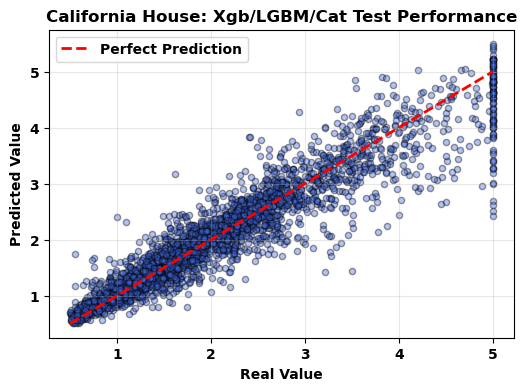

In [90]:

final_stacking_rmse = root_mean_squared_error(y_test, y_pred_final_stacked)
final_stacking_log_rmse = root_mean_squared_error(y_test, y_pred_log_stacked)

print("\n--- FINAL STACKING ENSEMBLE REPORT ---")
print(f"Base Models' Avg RMSE (Log): {(study_xgb.best_value + study_lgbm.best_value + study_cat.best_value) / 3:.4f}")
print(f"Stacking Ensemble RMSE (Log): {final_stacking_log_rmse-1:.4f}")
print(f"Stacking Ensemble RMSE (Original): {final_stacking_rmse:.4f}")
print("---------------------------------------")


fig, ax = functions.get_prediction_graph({'California House: Xgb/LGBM/Cat':(None, y_pred_final_stacked)}, y_test=y_test)

In [ ]:
from sklearn.base import BaseEstimator, RegressorMixin, clone
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score

from xgboost import XGBClassifier
from catboost import CatBoostRegressor


# ==========================================================
# 1. SMART SOFT MODEL SELECTOR – FIXED VERSION
# ==========================================================

class SmartSoftModelSelector(BaseEstimator, RegressorMixin):
    def __init__(self, estimators, selector_model=None, cv=5):
        self.estimators = estimators
        self.model_names = [name for name, _ in estimators]
        self.cv = cv
        
        self.selector_model = selector_model if selector_model else XGBClassifier(
            n_estimators=300,
            max_depth=6,
            learning_rate=0.05,
            device='cuda',
            tree_method='hist',
            n_jobs=1,
            random_state=42
        )

    def fit(self, X, y):
        X = pd.DataFrame(X).reset_index(drop=True)
        y = np.array(y)

        kf = KFold(n_splits=self.cv, shuffle=True, random_state=42)
        
        # OOF matrix: [n_samples, n_models]
        oof_preds = np.zeros((len(X), len(self.estimators)))

        print("\n=== Training Esperti con OOF ===")
        for m_idx, (name, model) in enumerate(self.estimators):
            print(f" -> {name}")
            for train_i, valid_i in kf.split(X):
                X_tr, X_val = X.iloc[train_i], X.iloc[valid_i]  # FIXED
                y_tr = y[train_i]
                
                model_fold = clone(model)
                model_fold.fit(X_tr, y_tr)
                oof_preds[valid_i, m_idx] = model_fold.predict(X_val)

        # Selettore target = il modello con errore minore per ciascun sample
        errors = np.abs(oof_preds - y.reshape(-1, 1))
        y_best = errors.argmin(axis=1)

        print("=== Training Gating Network ===")
        self.selector_model.fit(X, y_best)

        # Ora alleniamo definitivamente ogni esperto sul 100% del dataset
        print("=== Training Esperti Finali (100%) ===")
        self.fitted_estimators_ = []
        for name, model in self.estimators:
            m = clone(model)
            m.fit(X, y)
            self.fitted_estimators_.append(m)

        return self

    def predict(self, X):
        X = pd.DataFrame(X)
        base_preds = np.column_stack([m.predict(X) for m in self.fitted_estimators_])
        weights = self.selector_model.predict_proba(X)
        return np.sum(base_preds * weights, axis=1)



# ==========================================================
# 2. RESIDUAL CORRECTOR – FIXED VERSION
# ==========================================================

class ResidualCorrectedMoE(BaseEstimator, RegressorMixin):
    def __init__(self, base_moe_model, corrector_model=None, cv=5):
        self.base_moe_model = base_moe_model
        self.cv = cv
        
        self.corrector_model = corrector_model if corrector_model else CatBoostRegressor(
            iterations=500,
            depth=6,
            learning_rate=0.03,
            task_type='GPU',
            devices='0',
            verbose=0,
            random_state=42,
            allow_writing_files=False
        )

    def fit(self, X, y):
        X = pd.DataFrame(X).reset_index(drop=True)
        y = np.array(y)

        print("\n=== Calcolo Residui OOF del MoE ===")

        kf = KFold(n_splits=self.cv, shuffle=True, random_state=42)
        oof_preds = np.zeros(len(X))

        for train_i, valid_i in kf.split(X):
            X_tr, X_val = X.iloc[train_i], X.iloc[valid_i]  # FIXED
            y_tr = y[train_i]

            # clone MoE e retrain sul fold
            moe_fold = clone(self.base_moe_model)
            moe_fold.fit(X_tr, y_tr)
            oof_preds[valid_i] = moe_fold.predict(X_val)

        residuals = y - oof_preds
        print(f" Residual mean: {residuals.mean():.4f}")
        print(f" Residual std : {residuals.std():.4f}")

        print("\n=== Training Correttore Residui ===")
        self.corrector_model.fit(X, residuals)

        # salva modello MoE finale (train 100%)
        self.base_moe_model.fit(X, y)

        return self

    def predict(self, X):
        X = pd.DataFrame(X)
        base_pred = self.base_moe_model.predict(X)
        correction = self.corrector_model.predict(X)
        return base_pred + correction


In [ ]:

# Creiamo e addestriamo il sistema MoE
moe_model = SmartSoftModelSelector(estimators=estimators)
moe_model.fit(X_train_scaled_df, y_train_full_log)

# ---------------------------------------------------------
# 6. AGGIUNTA DEL CORRETTORE DEI RESIDUI (Residual Learning)
# ---------------------------------------------------------
print("\n6. Training Correttore dei Residui...")
# Costruzione Finale
# Nota: passiamo il moe_model già addestrato, ma la classe ResidualCorrectedMoE
# userà cross_val_predict che internamente farà cloni e fit su fold.
final_system = ResidualCorrectedMoE(base_moe_model=moe_model)
final_system.fit(X_train_scaled_df, y_train_full_log)

# Valutazione
y_pred_log = final_system.predict(X_test_scaled_df)
y_pred = np.expm1(y_pred_log)

final_rmse = root_mean_squared_error(y_test, y_pred)
final_r2 = r2_score(y_test, y_pred)

print(f"\n==========================================")
print(f" RISULTATI FINALI OTTIMIZZATI")
print(f"==========================================")
print(f" RMSE: {final_rmse:.5f}")
print(f" R^2 : {final_r2:.5f}")
print(f"==========================================")

# Plot veloce
corrections_test = final_system.corrector_model.predict(X_test_scaled_df)
base_preds_test = final_system.base_moe_model.predict(X_test_scaled_df)


=== Training Esperti con OOF ===
 -> xgb
 -> lgbm
 -> cat
=== Training Gating Network ===
=== Training Esperti Finali (100%) ===

6. Training Correttore dei Residui...

=== Calcolo Residui OOF del MoE ===

=== Training Esperti con OOF ===
 -> xgb
 -> lgbm
 -> cat
=== Training Gating Network ===
=== Training Esperti Finali (100%) ===

=== Training Esperti con OOF ===
 -> xgb
 -> lgbm
 -> cat
=== Training Gating Network ===
=== Training Esperti Finali (100%) ===

=== Training Esperti con OOF ===
 -> xgb
 -> lgbm
 -> cat
=== Training Gating Network ===
=== Training Esperti Finali (100%) ===

=== Training Esperti con OOF ===
 -> xgb
 -> lgbm
 -> cat
=== Training Gating Network ===
=== Training Esperti Finali (100%) ===

=== Training Esperti con OOF ===
 -> xgb
 -> lgbm
 -> cat
=== Training Gating Network ===
=== Training Esperti Finali (100%) ===
 Residual mean: 0.0001
 Residual std : 0.1063

=== Training Correttore Residui ===

=== Training Esperti con OOF ===
 -> xgb
 -> lgbm
 -> cat
==

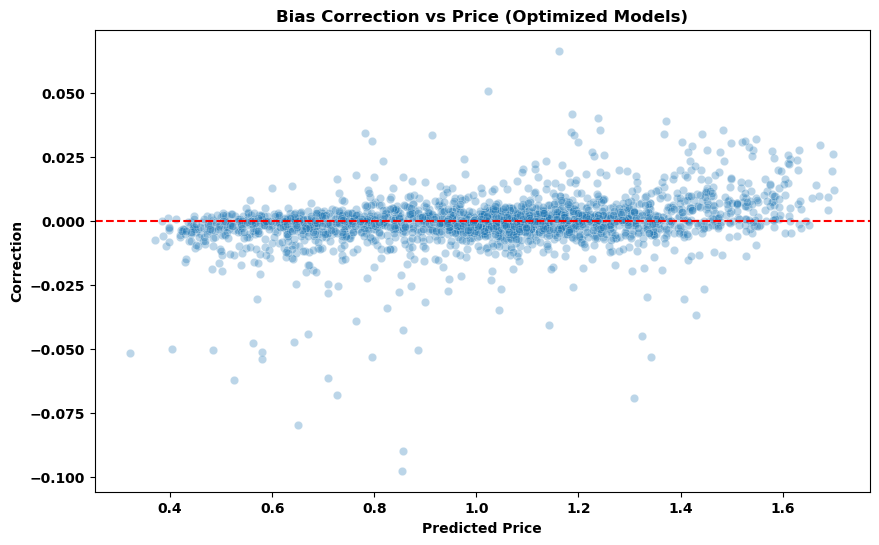

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x=base_preds_test, y=corrections_test, alpha=0.3)
plt.axhline(0, color='red', linestyle='--')
plt.title("Bias Correction vs Price (Optimized Models)")
plt.xlabel("Predicted Price")
plt.ylabel("Correction")
plt.show()

Dimensioni originali: (10447, 59) (Righe, Feature)


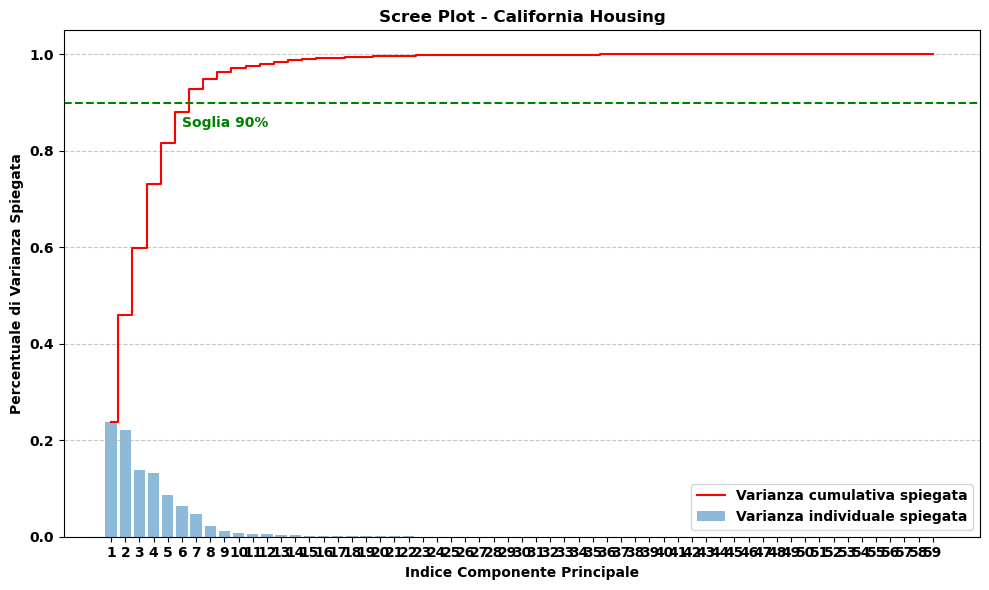


--- Analisi Varianza ---
Componente 1: 23.89% (Cumulativo: 23.89%)
Componente 2: 22.10% (Cumulativo: 45.99%)
Componente 3: 13.89% (Cumulativo: 59.89%)
Componente 4: 13.18% (Cumulativo: 73.06%)
Componente 5: 8.61% (Cumulativo: 81.67%)
Componente 6: 6.40% (Cumulativo: 88.07%)
Componente 7: 4.79% (Cumulativo: 92.87%)
Componente 8: 2.14% (Cumulativo: 95.01%)
Componente 9: 1.26% (Cumulativo: 96.26%)
Componente 10: 0.84% (Cumulativo: 97.10%)
Componente 11: 0.52% (Cumulativo: 97.62%)
Componente 12: 0.47% (Cumulativo: 98.10%)
Componente 13: 0.43% (Cumulativo: 98.52%)
Componente 14: 0.32% (Cumulativo: 98.85%)
Componente 15: 0.20% (Cumulativo: 99.05%)
Componente 16: 0.16% (Cumulativo: 99.21%)
Componente 17: 0.14% (Cumulativo: 99.35%)
Componente 18: 0.11% (Cumulativo: 99.47%)
Componente 19: 0.09% (Cumulativo: 99.56%)
Componente 20: 0.08% (Cumulativo: 99.64%)
Componente 21: 0.06% (Cumulativo: 99.70%)
Componente 22: 0.05% (Cumulativo: 99.75%)
Componente 23: 0.04% (Cumulativo: 99.79%)
Componente 24

In [ ]:
from sklearn.preprocessing import StandardScaler

# 1. Caricamento e Preparazione
# -----------------------------
X = california_handler.df

print(f"Dimensioni originali: {X.shape} (Righe, Feature)")

# Standardizzazione (CRUCIALE: media=0, varianza=1)
# Senza questo, feature come 'Population' (migliaia) dominerebbero su 'AveRooms' (unità)
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# 2. PCA Completa (Senza ridurre ancora)
# -----------------------------
# Se non specifichiamo n_components, Scikit-learn le calcola tutte (in questo caso 8)
pca = PCA()
pca.fit(X_std)

# Calcoliamo la varianza spiegata cumulativa
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

# 3. Creazione dello Scree Plot
# -----------------------------
plt.figure(figsize=(10, 6))

# Bar plot per la varianza della singola componente
plt.bar(range(1, len(exp_var_pca) + 1), exp_var_pca, alpha=0.5, align='center',
        label='Varianza individuale spiegata')

# Step plot per la varianza cumulativa
plt.step(range(1, len(cum_sum_eigenvalues) + 1), cum_sum_eigenvalues, where='mid',
         label='Varianza cumulativa spiegata', color='red')

# Etichette e abbellimenti
plt.ylabel('Percentuale di Varianza Spiegata')
plt.xlabel('Indice Componente Principale')
plt.title('Scree Plot - California Housing')
plt.legend(loc='best')
plt.xticks(range(1, len(exp_var_pca) + 1)) # Mostra tutti i numeri sull'asse X
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Linea guida al 90% (una soglia comune)
plt.axhline(y=0.90, color='green', linestyle='--', label='Soglia 90%')
plt.text(6, 0.85, 'Soglia 90%', color = 'green', fontsize=10)

plt.tight_layout()
plt.show()

# Stampa dei valori esatti per decidere
print("\n--- Analisi Varianza ---")
for i, (var, cum) in enumerate(zip(exp_var_pca, cum_sum_eigenvalues)):
    print(f"Componente {i+1}: {var*100:.2f}% (Cumulativo: {cum*100:.2f}%)")